In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [68]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [69]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [70]:
train_df.shape

(3000888, 6)

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [72]:
train_df['date'] = pd.to_datetime(train_df["date"])

<AxesSubplot:xlabel='sales', ylabel='Count'>

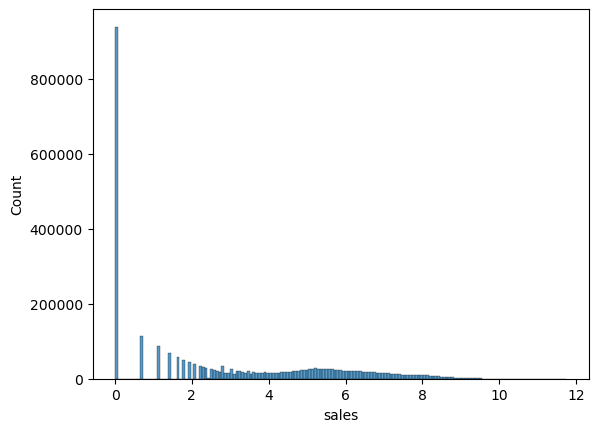

In [73]:
sns.histplot(np.log1p(train_df['sales']), kde=False)

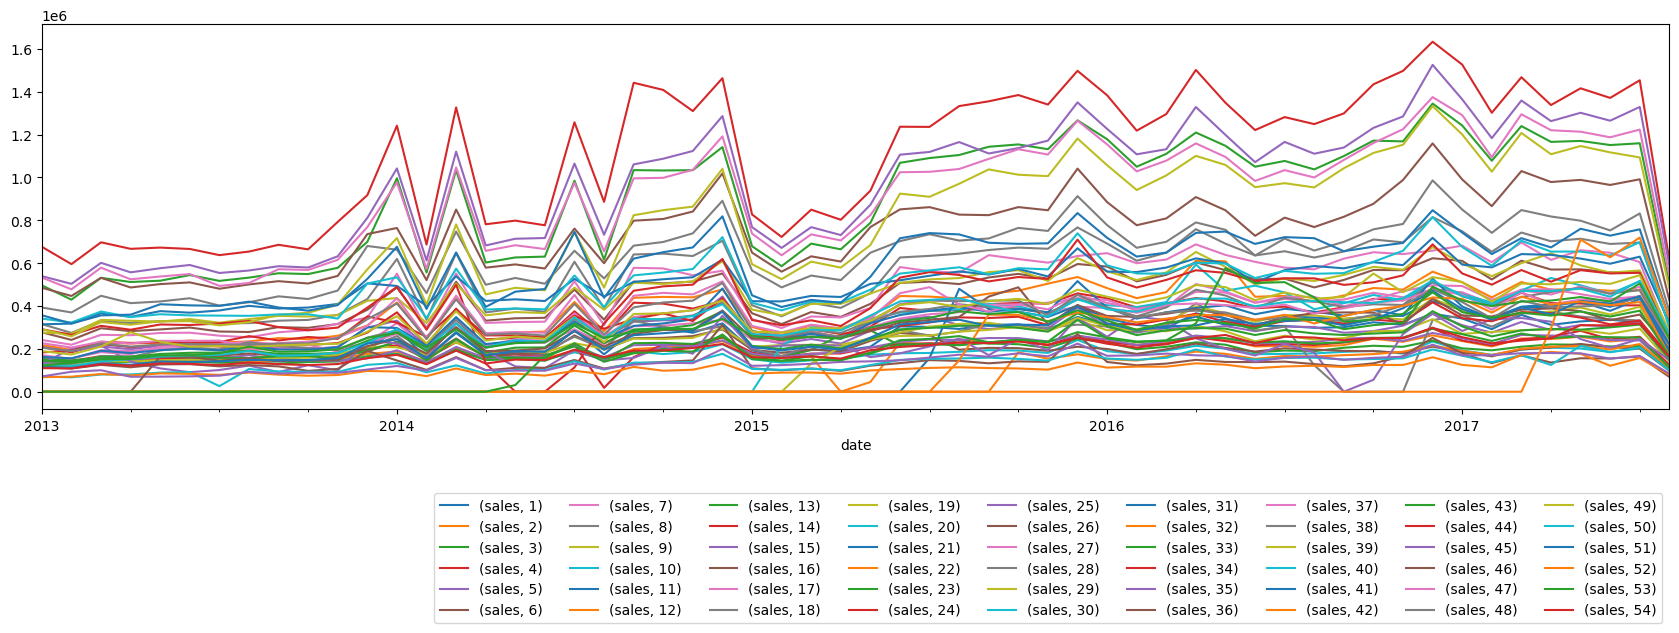

In [74]:
store_nbr_sales_per_month = train_df.groupby(['date', 'store_nbr']).agg({'sales': 'sum'}).unstack().resample('M').sum()
store_nbr_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1,-0.2), ncol=9)

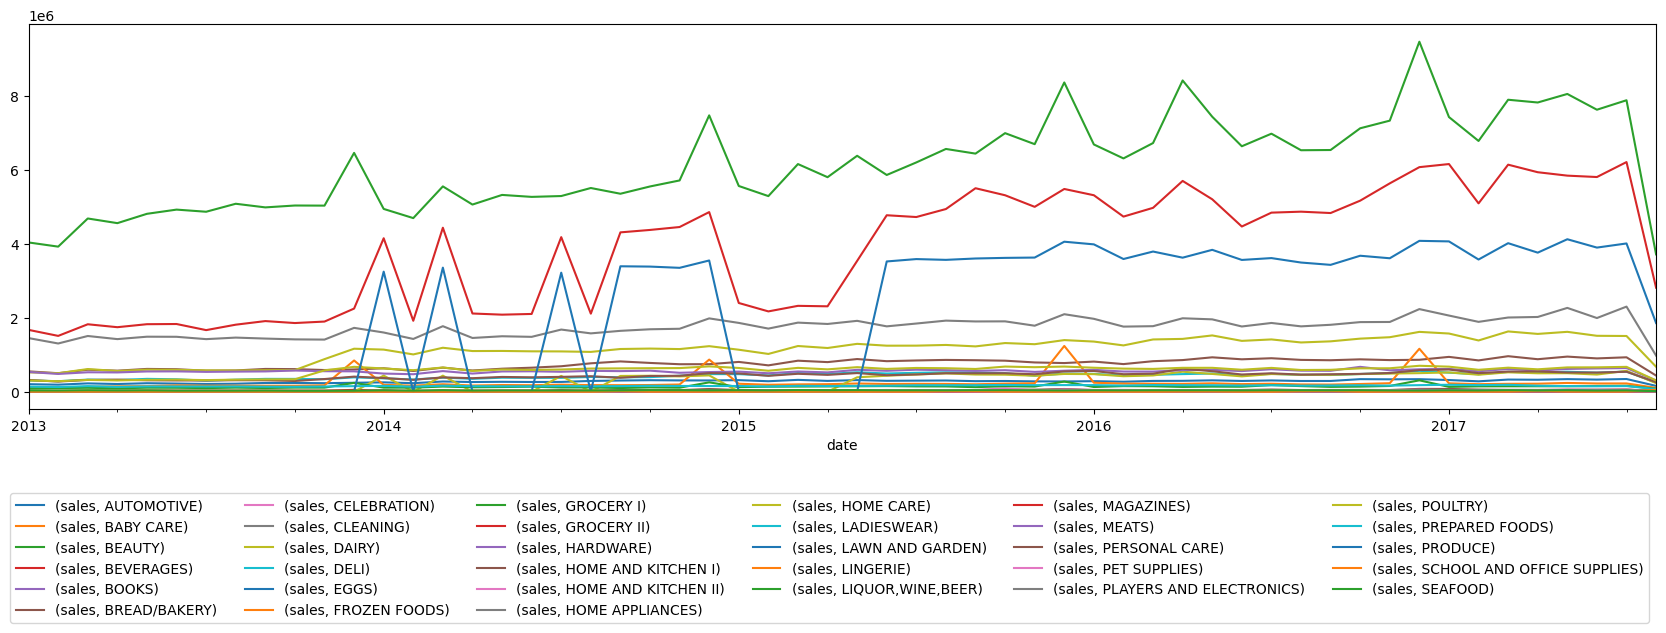

In [75]:
family_sales_per_month = train_df.groupby(['date', 'family']).aggregate({'sales': 'sum'}).unstack().resample('M').sum()
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -0.2), ncol=6)

<AxesSubplot:xlabel='onpromotion', ylabel='Count'>

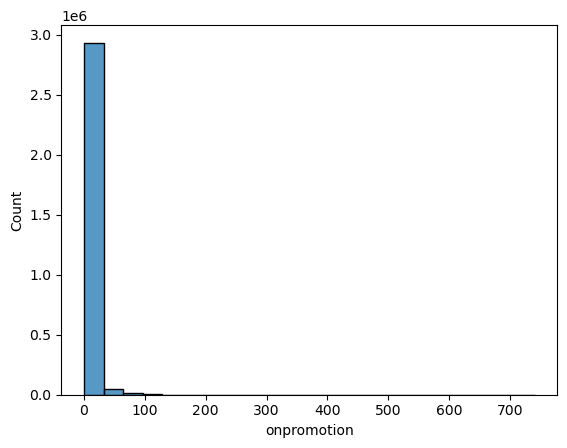

In [76]:
sns.histplot(data=train_df, x='onpromotion')

In [77]:
train_df['sales'] = np.log1p(train_df['sales'])

In [78]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [79]:
stores_df.shape

(54, 5)

In [80]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [81]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df.shape

(83488, 3)

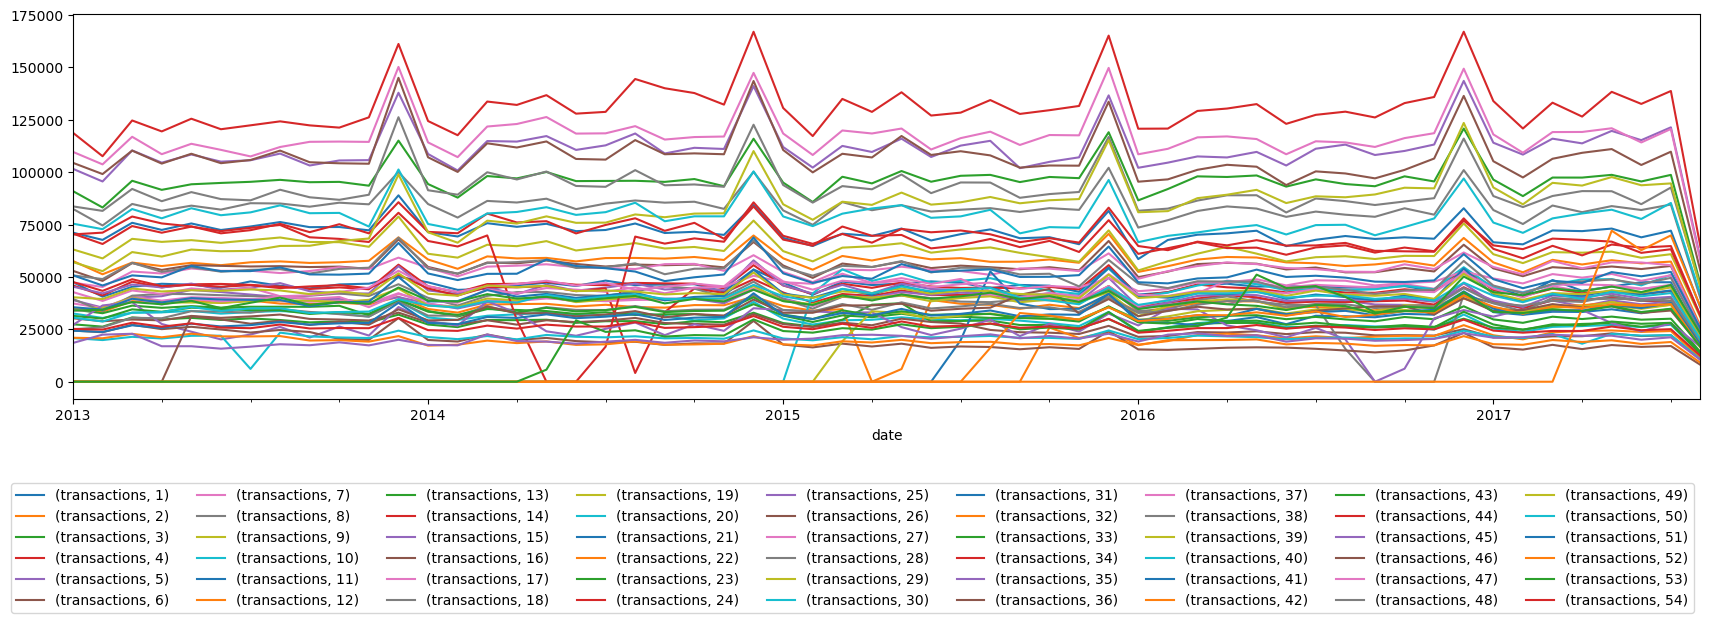

In [82]:
store_nbr_transactions_per_month = transactions_df.groupby(['date', 'store_nbr']).aggregate({'transactions': 'sum'}).unstack().resample('M').sum()
store_nbr_transactions_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1,-0.2), ncol=9)

In [83]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [84]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.shape

(28512, 5)

In [85]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [86]:
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df.shape

(350, 6)

In [87]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [88]:
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df['dcoilwtico'].fillna(method="bfill",inplace=True)
oil_df.shape

(1218, 2)

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

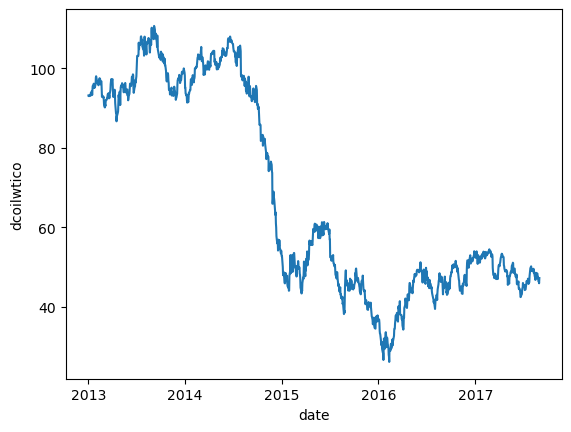

In [89]:
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')

In [107]:
def merge_data(df):
    df = df \
        .merge(stores_df, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_df, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_df, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_df, left_on="date", right_on="date", how="left") 
    return df

In [108]:
col = [
    'date',
    'store_nbr', 
    'family', 
    'sales', 
    'onpromotion', 
    'cluster', 
    'holiday_type', 
    'locale', 
    'description', 
    'transferred',
    'dcoilwtico'
]

In [109]:
def fill_na(df):
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    df['locale'] = df['locale'].fillna('Common')
    df['description'] = df['description'].fillna('None')
    df['transferred'] = df['transferred'].fillna(False)
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='bfill')
    return df

In [110]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [111]:
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [122]:
def random_noise(dataframe):
    return np.random.normal(scale=2.0, size=(len(dataframe),))
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7).mean()) + random_noise(
            dataframe)
    return dataframe

In [123]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df = merge_data(all_df)
all_df = all_df[col]
all_df = fill_na(all_df)
all_df = create_date_features(all_df)
all_df = lag_features(all_df, lags = [*range(1, 23),30,31,90,180,364])
all_df = roll_mean_features(all_df,[16,17,18,30])

In [124]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [125]:
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 7,30]
all_df = ewm_features(all_df, alphas, lags)

In [126]:
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['store_nbr'] = all_df['store_nbr'].astype('category')
all_df['cluster'] = all_df['cluster'].astype('category')
all_df['family'] = all_df['family'].astype('category')
all_df['holiday_type'] = all_df['holiday_type'].astype('category')
all_df['locale'] = all_df['locale'].astype('category')
all_df['description'] = all_df['description'].astype('category')

In [127]:
all_df

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year,sales_t-1,sales_t-2,sales_t-3,sales_t-4,sales_t-5,sales_t-6,sales_t-7,sales_t-8,sales_t-9,sales_t-10,sales_t-11,sales_t-12,sales_t-13,sales_t-14,sales_t-15,sales_t-16,sales_t-17,sales_t-18,sales_t-19,sales_t-20,sales_t-21,sales_t-22,sales_t-30,sales_t-31,sales_t-90,sales_t-180,sales_t-364,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,6,Common,Common,None,False,47.26,8,31,243,35,3,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.084802,5.650484,6.024556,5.951650,6.265727,5.679561,5.811536,6.347732,6.155947,6.471864,6.545467,5.881839,8.337250,9.045499,7.331329,8.590331,6.064014,6.064014,6.338358,6.045064,6.045064,6.329319,6.012643,6.012643,6.311631,5.957384,5.957384,6.244803
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,6,Common,Common,None,False,47.26,8,31,243,35,3,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.046987,4.745975,4.665032,4.874464,4.728272,4.726768,4.824025,3.940863,4.142182,4.765229,5.130857,4.648057,1.806032,4.535729,1.071965,6.101032,5.031759,5.031759,3.953042,5.016271,5.016271,3.969407,4.984993,4.984993,4.014010,4.894600,4.894600,4.210488
3029397,2017-08-31,9,PRODUCE,NaN,1,6,Common,Common,None,False,47.26,8,31,243,35,3,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.791824,7.207434,7.435206,7.258598,7.282127,6.944510,7.178887,7.812565,7.325513,7.281706,7.720754,7.098716,5.902388,9.098000,7.138595,5.389325,7.763152,7.763152,7.788738,7.735485,7.735485,7.765895,7.682595,7.682595,7.722496,7.532320,7.532320,7.590557
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,Common,Common,None,False,47.26,8,31,243,35,3,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.804021,5.209486,5.303305,4.934474,4.948760,5.003946,4.430817,5.318120,4.043051,1.945910,1.945910,2.833213,5.151282,2.514564,5.108745,7.171128,4.824483,4.824483,5.253514,4.845138,4.845138,5.186784,4.885929,4.

In [128]:
all_df = all_df.query("date > '2013-12-31'")
X = all_df.query("date <= '2017-08-15'")
X_test = all_df.query("date > '2017-08-15'")
X.drop(['date'], inplace=True, axis=1)
X_test.drop(['date', 'year'], inplace=True, axis=1)

In [129]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_t-1                     0.963883
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_t-7                     0.961233
sales_t-2                     0.958115
sales_t-3                     0.955286
sales_t-4                     0.953452
sales_t-6                     0.953263
sales_t-5                     0.952700
sales_t-14                    0.949117
sales_t-8                     0.949008
sales_t-9                     0.944701
sales_t-10                    0.942176
sales_t-13                    0.941201
sales_t-11                    0.940818
sales_t-12                    0.940049
sales_t-15                    0.937474
sales_t-21                    0.937108
sales_t-16               

In [130]:
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

In [131]:
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [132]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [133]:
X_train.dtypes

store_nbr                     category
family                        category
onpromotion                      int64
cluster                       category
holiday_type                  category
locale                        category
description                   category
transferred                       bool
dcoilwtico                     float64
month                            int64
day_of_month                     int64
day_of_year                      int64
week_of_year                     int64
day_of_week                      int64
sales_t-1                      float64
sales_t-2                      float64
sales_t-3                      float64
sales_t-4                      float64
sales_t-5                      float64
sales_t-6                      float64
sales_t-7                      float64
sales_t-8                      float64
sales_t-9                      float64
sales_t-10                     float64
sales_t-11                     float64
sales_t-12               

In [140]:
lgb_params={
    "metric":"mse",
    "boosting_type":"gbdt",
    "num_leaves":8,
    "learning_rate":0.2,
    "max_depth":7,
    "num_iterations":5000,
    "force_col_wise":True,
}

model_lgb = lgb.LGBMRegressor(**lgb_params) 
model_lgb.fit(        
        X_train,
        Y_train,
        eval_set =[( X_val,Y_val)],
        verbose =100,
        early_stopping_rounds = 200
)

[100]	valid_0's l2: 0.175914
[200]	valid_0's l2: 0.163075
[300]	valid_0's l2: 0.157356
[400]	valid_0's l2: 0.153592
[500]	valid_0's l2: 0.150828
[600]	valid_0's l2: 0.148552
[700]	valid_0's l2: 0.146519
[800]	valid_0's l2: 0.145256
[900]	valid_0's l2: 0.144175
[1000]	valid_0's l2: 0.143256
[1100]	valid_0's l2: 0.142291
[1200]	valid_0's l2: 0.141664
[1300]	valid_0's l2: 0.141124
[1400]	valid_0's l2: 0.140609
[1500]	valid_0's l2: 0.140235
[1600]	valid_0's l2: 0.139865
[1700]	valid_0's l2: 0.139573
[1800]	valid_0's l2: 0.139196
[1900]	valid_0's l2: 0.13876
[2000]	valid_0's l2: 0.138415
[2100]	valid_0's l2: 0.13817
[2200]	valid_0's l2: 0.137927
[2300]	valid_0's l2: 0.137667
[2400]	valid_0's l2: 0.137494
[2500]	valid_0's l2: 0.137312
[2600]	valid_0's l2: 0.137153
[2700]	valid_0's l2: 0.136999
[2800]	valid_0's l2: 0.136854
[2900]	valid_0's l2: 0.136642
[3000]	valid_0's l2: 0.136462
[3100]	valid_0's l2: 0.136351
[3200]	valid_0's l2: 0.136245
[3300]	valid_0's l2: 0.136169
[3400]	valid_0's l2: 

LGBMRegressor(force_col_wise=True, learning_rate=0.2, max_depth=7, metric='mse',
              num_iterations=5000, num_leaves=8)

In [144]:
Y_val_pred = model_lgb.predict(X_val)
Y_val_pred[Y_val_pred < 0] = 0

In [145]:
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred)))

0.36664524921996944
0.13442873877557351


In [163]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [148]:
pred_lgb = model_lgb.predict(X_test)
Y_val_pred[Y_val_pred < 0] = 0

In [156]:
sub = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
sub.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [165]:
sub['sales'] = np.expm1(pred_lgb)

In [166]:
sub.to_csv("/kaggle/working/sub.csv",index=False)

In [172]:
sub = pd.read_csv("/kaggle/working/sub.csv")
sub

,id,sales
0,3000888,4.778688
1,3000889,0.027679
2,3000890,5.677081
3,3000891,2346.007841
4,3000892,0.062120
...,...,...
28507,3029395,67.422648
28508,3029396,43.591254
28509,3029397,109.513166
28510,3029398,99.408615


In [188]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [189]:
rec_pred_lgb = recursive_predict(model_lgb)

In [190]:
sub['sales'] = np.expm1(rec_pred_lgb)

In [191]:
sub.to_csv("/kaggle/working/sub2.csv",index=False)